# Vit Transformer

## ViT

![alt text](https://drive.google.com/uc?export=view&id=1J5TvycDPs8pzfvlXvtO5MCFBy64yp9Fa)

In [1]:
!pip -q install einops # Инициализация модели и функции Trainer

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
#from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

![](https://amaarora.github.io/images/vit-01.png)

## Часть 1. Patch Embedding, CLS Token, Position Encoding

![](https://amaarora.github.io/images/vit-02.png)

In [3]:
# input image `B, C, H, W`
x = torch.randn(1, 3, 224, 224)
# 2D conv
conv = nn.Conv2d(3, 768, 16, 16)
conv(x).reshape(-1, 196).transpose(0,1).shape

torch.Size([196, 768])

In [4]:
class PatchEmbedding(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = (img_size, img_size)
        self.patch_size = (patch_size, patch_size)
        self.num_patches = (self.img_size[1] // self.patch_size[1]) * (self.img_size[0] // self.patch_size[0])
        self.patch_embeddings = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, image):
        # B, C, H, W = image.shape # assert
        patches = self.patch_embeddings(image).flatten(2).transpose(1, 2)
        #patches = patches.reshape(-1, 196).transpose(0,1)
        return patches

In [5]:
patch_embed = PatchEmbedding()
x = torch.randn(1, 3, 224, 224)
patch_embed(x).shape 

torch.Size([1, 196, 768])

![](https://amaarora.github.io/images/vit-03.png)

## Часть 2. Transformer Encoder

![](https://amaarora.github.io/images/ViT.png)

![](https://amaarora.github.io/images/vit-07.png)

In [6]:
class MLP(nn.Module):
    def __init__(self, in_features, mlp_ratio, out_features=None, drop=0.):
        super().__init__()
        hidden_features = int(in_features * mlp_ratio)
        out_features = int(in_features if not out_features else out_features)

        # Linear Layers
        self.l1 = nn.Linear(in_features, hidden_features)
        self.l2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.l1(x)
        x = F.gelu(x)
        x = self.drop(x)
        x = self.l2(x)
        x = self.drop(x)
        return x

In [7]:
x = torch.randn(1, 197,768)
mlp = MLP(768, 4)
out = mlp(x)
out.shape

torch.Size([1, 197, 768])

In [8]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., out_drop=0.):
        # dim = 768
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias = qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.out = nn.Linear(dim, dim)
        self.out_drop = nn.Dropout(out_drop)

    def forward(self, x):
        # линейный слой
        # 1, 197, 768 -> 1, 197, 2304
        qkv = self.qkv(x)
        
        # делим на три равные части
        # 1, 197, 2304 -> 3, 1, 197, 768 
        qkv = qkv.chunk(3, dim=-1)
        
        # destack
        # b - размер батча
        # n - num_heads
        # h - количество патчей + токен (196 + 1)
        # d - dim // num_heads
        # 1, 8, 197, 96
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.num_heads), qkv)

        # q @ k(t)
        # 1, 8, 197, 96 @ 1, 8, 96, 197 ->  1, 8, 197, 197
        attn = q @ k.transpose(-1, -2) * self.scale
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)

        # attn @ v
        # 1, 8, 197, 197 @ 1, 8, 197, 96 -> 1, 8, 197, 96 
        out = attn @ v
        # 1, 8, 197, 96 -> 1, 197, 768
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.out(out)
        return self.out_drop(out)



![](https://amaarora.github.io/images/vit-08.png)

In [9]:
# attn = (q @ k.transpose(-2, -1)) * self.scale
# attn = attn.softmax(dim=-1)

In [10]:
x = torch.randn(1, 197, 768)
attention = Attention(768, 8)
out = attention(x)
out.shape

torch.Size([1, 197, 768])

In [11]:
class Block(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4, drop_rate=0.):
        super().__init__()

        # Normalization
        self.norm1 = nn.LayerNorm(dim)

        # Attention
        self.attn = Attention(dim, num_heads)

        # Dropout
        self.drop = nn.Dropout(drop_rate)

        # Normalization
        self.norm2 = nn.LayerNorm(dim)

        # MLP
        self.mlp = MLP(dim, mlp_ratio, dim)

    def forward(self, x):
        # Attetnion
        attn = self.norm1(x)
        attn = self.attn(attn)
        x = attn + x

        # MLP
        mlp = self.norm2(x)
        mlp = self.mlp(mlp)
        x = mlp + x
        return x

In [12]:
x = torch.randn(1, 197, 768)
block = Block(768, 8)
out = attention(x)
out.shape

torch.Size([1, 197, 768])

В оригинальной реализации теперь используется [DropPath](https://github.com/rwightman/pytorch-image-models/blob/e98c93264cde1657b188f974dc928b9d73303b18/timm/layers/drop.py)

In [13]:
class Transformer(nn.Module):
    def __init__(self, depth, dim, num_heads=8, mlp_ratio=4, drop_rate=0.):
        super().__init__()
        self.blocks = nn.ModuleList([
            Block(dim, num_heads, mlp_ratio, drop_rate)
            for i in range(depth)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

In [14]:
x = torch.randn(1, 197, 768)
block = Transformer(12, 768)
out = attention(x)
out.shape

torch.Size([1, 197, 768])

![](https://amaarora.github.io/images/vit-06.png)

In [15]:
from torch.nn.modules.normalization import LayerNorm

class ViT(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=3, 
                 qkv_bias=False, drop_rate=0.2,):
        super().__init__()

        # Path Embeddings, CLS Token, Position Encoding
        self.patch_embed = PatchEmbedding(img_size=img_size,
                                          patch_size=patch_size,
                                          in_chans=in_chans,
                                          embed_dim=embed_dim)
        
        # Присвоение переменных
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

        # Transformer Encoder
        self.transformer = Transformer(depth, 
                                       embed_dim, 
                                       mlp_ratio=mlp_ratio, 
                                       num_heads=num_heads, 
                                       drop_rate=drop_rate)
        
        
        # Classifier
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes))

        # Dropout
        self.drop = nn.Dropout(drop_rate)

    def forward(self, x):
        B = x.shape[0]
      
        # Path Embeddings, CLS Token, Position Encoding
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.drop(x)

        # Transformer Encoder
        x = self.transformer(x)

        # Classifier
        x = x.mean(dim=1)
        x = self.mlp_head(x)
        return x

In [16]:
x = torch.randn(1, 3, 224, 224)
vit = ViT()
out = vit(x)
out.shape

torch.Size([1, 1000])

# Домашнее задание


1. Выбрать датасет для классификации изображений с размерностью 64x64+ 
2. Обучить ViT на таком датасете.
3. Попробовать поменять размерности и посмотреть, что поменяется при обучении.


Примечание:
- Датасеты можно взять [тут](https://pytorch.org/vision/stable/datasets.html#built-in-datasets) или найти в другом месте.
- Из за того, что ViT учится медленно, количество примеров в датасете можно ограничить до 1к-5к.

In [17]:
import torchvision
from torchvision import transforms as tvt
from torchvision.utils import make_grid
from matplotlib import pyplot as plt 

trans = tvt.Compose([
    tvt.ToTensor(),
    tvt.Resize(64)
])

# STL10 - датасет из картинок 10 классов: 
# airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

# тренировочные картинки, 5к
stl10_train = torchvision.datasets.STL10('./',
                                         split = 'train',
                                         transform=trans,
                                         download=True)
# валидационные картинки, 800
stl10_val = torchvision.datasets.STL10('./',
                                       split = 'test',
                                       transform=trans)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./stl10_binary.tar.gz to ./


In [18]:
data_loader_train = torch.utils.data.DataLoader(stl10_train,
                                                batch_size=128,
                                                shuffle=True)

data_loader_val = torch.utils.data.DataLoader(stl10_val,
                                              batch_size=128,
                                              shuffle=True)

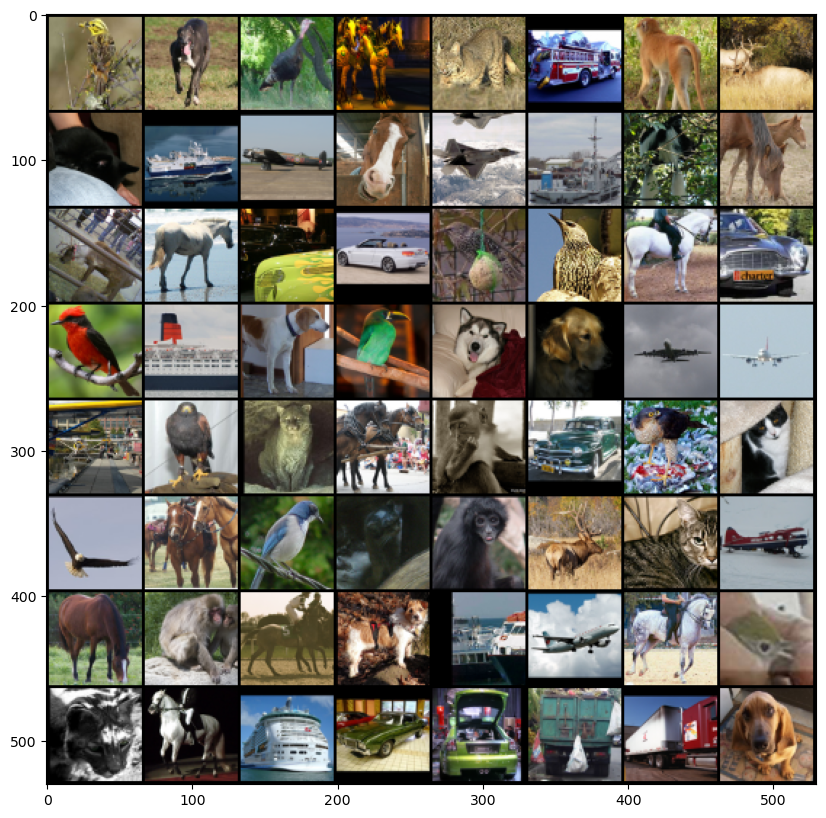

In [19]:
plt.figure(figsize=(10, 10))
l = [i[0] for i in stl10_train][:64]
plt.imshow(make_grid(l).permute(1, 2, 0))
plt.show()

## Pytorch Lightning

In [20]:
import pytorch_lightning as ptl
from pytorch_lightning.loggers import WandbLogger

torch.random.manual_seed(0)
ptl.seed_everything(0)

0

In [21]:
class ViT_PTL(ptl.LightningModule):  
    def __init__(self):
        super().__init__()
        # Задается архитектура нейросети
        self.layers = ViT(img_size=64, num_classes=10, num_heads=12, drop_rate=0.3).to(device)
        # Объявляется функция потерь
        self.loss_func = nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.layers(x)
  
    # Настраиваются параметры обучения
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y_one_hot = F.one_hot(y, 10).float()
        pred = self.layers(x)
        loss = self.loss_func(pred, y_one_hot)
        accuracy = torch.sum(y == pred.argmax(dim=-1)).item() / (len(y) * 1.0)
        self.log('train_loss', loss)
        self.log('train_acc', torch.tensor(accuracy), prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y_one_hot = F.one_hot(y, 10).float()
        pred = self.layers(x)
        loss = self.loss_func(pred, y_one_hot)
        accuracy = torch.sum(y == pred.argmax(dim=-1)).item() / (len(y) * 1.0)
        self.log('valid_loss', loss)
        self.log('valid_acc', torch.tensor(accuracy), prog_bar=True)

    # Настраиваются параметры тестирования
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(device)
        y_one_hot = F.one_hot(y, 10).float()
        pred = self.layers(x)
        loss = self.loss_func(pred, y_one_hot)
        pred = torch.argmax(pred, dim=1)
        accuracy = torch.sum(y == pred.argmax(dim=-1)).item() / (len(y) * 1.0)
        self.log('test_loss', loss, prog_bar=True, on_step=True, logger=True)
        self.log('test_acc', torch.tensor(accuracy), prog_bar=True, on_step=True, logger=True)
        output = dict({
            'test_loss': loss,
            'test_acc': torch.tensor(accuracy),
        })
        return output

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [22]:
# логгер
wandb_logger = WandbLogger(project='ViT')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [23]:
# Инициализация модели и функции Trainer
ViT_model = ViT_PTL()
trainer = ptl.Trainer(accelerator="gpu",
                      max_epochs=50,
                      logger=wandb_logger,
                      log_every_n_steps=40) 

# Обучение модели
trainer.fit(ViT_model, data_loader_train, data_loader_val)
trainer.save_checkpoint('./model')

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:491: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [26]:
# Тестирование модели
trainer.test(ViT_model, data_loader_val)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.08287499845027924    │
│      test_loss_epoch      │     2.771275520324707     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 2.771275520324707, 'test_acc_epoch': 0.08287499845027924}]

pred: 6 
true: 3


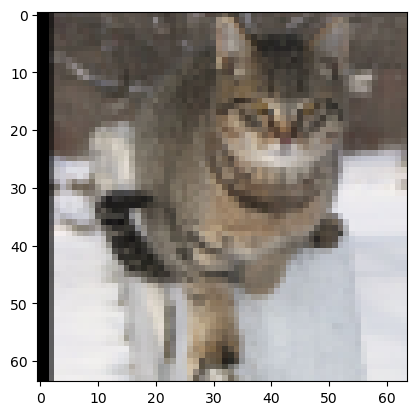

In [27]:
X, Y = stl10_val[23]
out = ViT_model(X.unsqueeze(0))
print('pred:', out.softmax(dim=1).argmax().numpy(), '\ntrue:', Y)
plt.imshow(X.permute(1, 2, 0))
plt.show()